In [1]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import time

import cv2
import matplotlib.pyplot as plt

/Users/ashrock_m13/Ashrockzzz/2024/7th_sem/NNDL/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SegmentationModel(nn.Module):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch=arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        params = smp.encoders.get_preprocessing_params(encoder_name)

        self.std = torch.tensor(params["std"],).view(1, 3, 1, 1)
        self.mean = torch.tensor(params["mean"],).view(1, 3, 1, 1)

        self.loss_fn = smp.losses.DiceLoss(
            mode="binary",
            from_logits=True,
        )
    
    def forward(self, im):
        im = (im - self.mean) / self.std
        return self.model(im)

In [3]:
model = torch.load("./model/model.pth", map_location=torch.device('cpu'))

/var/folders/79/k0pjppyx72xcfj5m7k0_zjqm0000gp/T/ipykernel_3775/3898580339.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./model/model.pth", map_lo

In [4]:
model.eval()

SegmentationModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [5]:
def maskImage(filePath):
    image = cv2.imread(filePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (736, 736))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    image = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)
    mask = model(image)
    mask = torch.sigmoid(mask)
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze().detach().numpy())

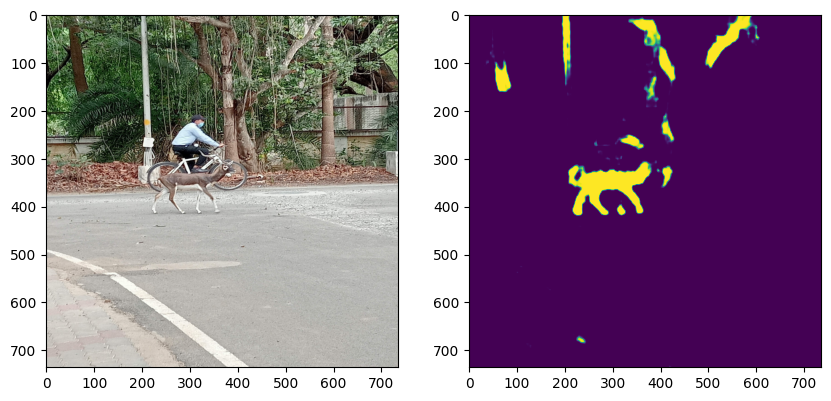

In [6]:
maskImage("test/deer.png")

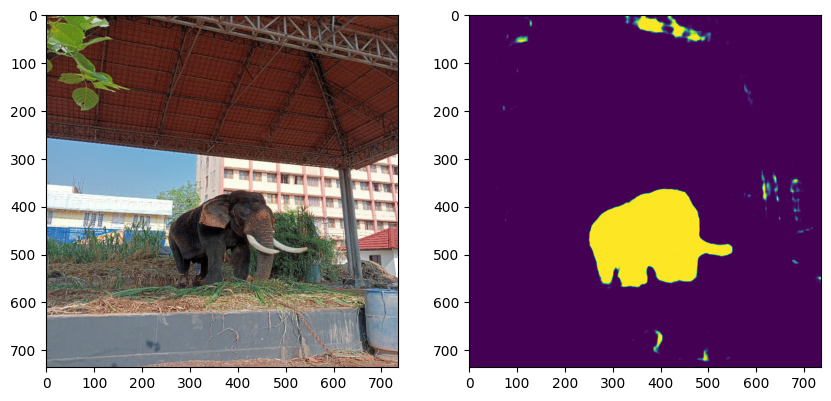

In [7]:
maskImage("test/elephant.png")

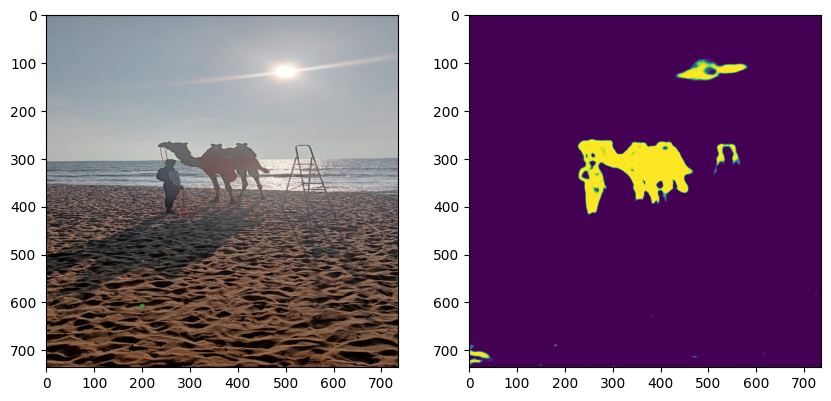

In [8]:
maskImage("test/camel.png")

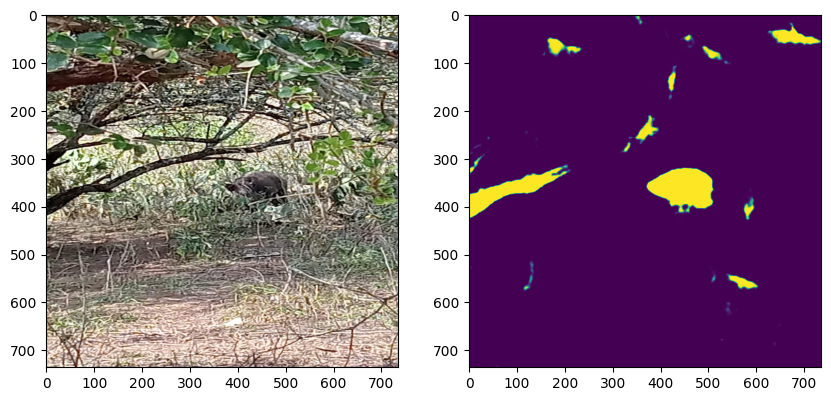

In [9]:
maskImage("test/unclear.png")

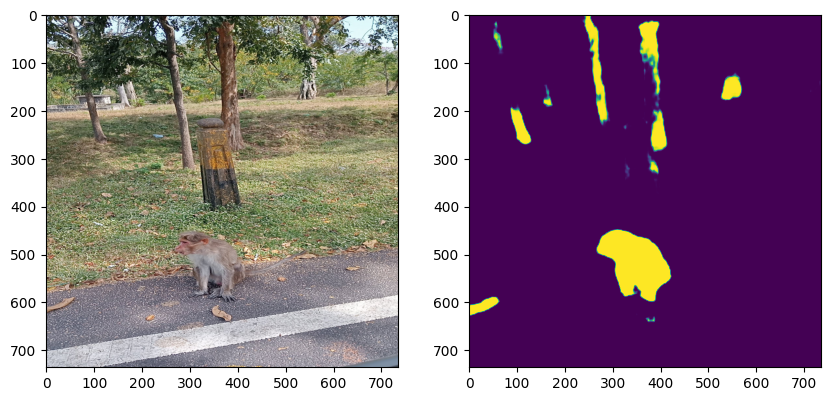

In [10]:
maskImage("test/monkey.png")

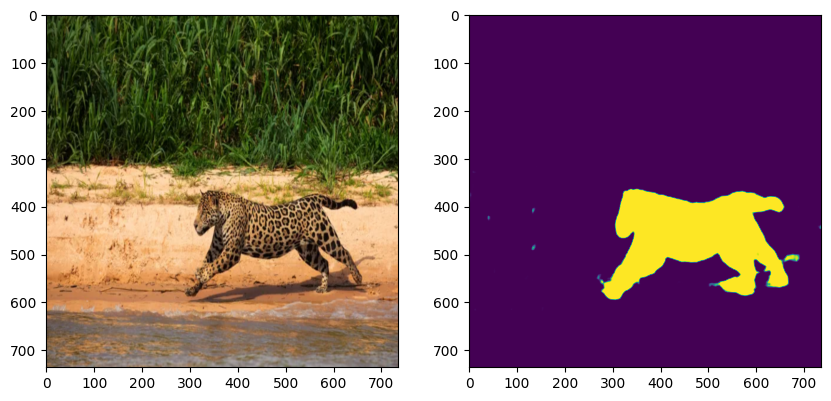

In [11]:
maskImage('test/jaguar.png')

## Videos

In [12]:
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (256, 256))
    frame = torch.from_numpy(frame).float().permute(2, 0, 1).unsqueeze(0)
    return frame

def perform_inference(model, frame):
    inference_start_time = time.time()
    mask = model(frame.half())
    mask = torch.sigmoid(mask)
    mask = mask.float().squeeze().detach().numpy()
    inference_time = time.time() - inference_start_time
    return mask, inference_time

def postprocess_frame(mask):
    return 0


def maskVideo(filePath):
    video = cv2.VideoCapture(filePath)
    while True:
        # Record the start time before processing each frame
        start_time = time.time()
        ret, frame = video.read()
        frame_org = frame
        if ret:
            # Preprocessing
            preprocessing_start_time = time.time()
            frame = preprocess_frame(frame)
            preprocessing_time = time.time() - preprocessing_start_time
            # Inference
            mask, inference_time = perform_inference(model, frame)
            # Post-processing
            post_processing_time = postprocess_frame(mask)
            # Calculate FPS and frame time
            total_time = time.time() - start_time
            fps = 1.0 / total_time
            frame_time = total_time * 1000.0  # Convert to milliseconds
            # Print FPS and frame time
            print(f"FPS: {fps:.2f}, Frame Time: {frame_time:.2f} ms, "
                f"Preprocessing Time: {preprocessing_time:.2f} s, "
                f"Inference Time: {inference_time:.2f} s, "
                f"Post-processing Time: {post_processing_time:.2f} s", end="\r")
            # Display the processed frame (mask) if you need to

            # Add to original frame
            blue_overlay = frame_org.copy()
            mask = cv2.resize(mask, (frame_org.shape[1], frame_org.shape[0]))
            blue_overlay[:, :, 0] = mask * 255
            cv2.addWeighted(blue_overlay, 0.5, frame_org, 0.5, 0, frame_org)

            # Display the frame
            cv2.imshow("Frame", frame_org)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break
        else:
            break

In [13]:
# maskVideo("test/video/cat.mp4")

In [14]:
# maskVideo("test/video/cheetah.mp4")

In [ ]:
maskVideo("test/video/cheetah_fast.mp4")

2024-11-06 16:17:38.906 python[3775:14724] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-06 16:17:38.906 python[3775:14724] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 